## Observations

In [164]:
using LinearAlgebra
using Plots
using ProfileView

In [595]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [182]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

In [166]:
BUDGET = 1

1

In [167]:
testfn = TestFunction(
    1,
    [-15. 15.],
    [0.],
    x -> (sin(first(x)) * first(x)^2),
    x -> [sin(first(x)) * 2first(x) + cos(first(x))*first(x)^2]
)

TestFunction(1, [-15.0 15.0], [0.0], var"#7771#7773"(), var"#7772#7774"())

In [603]:
n, h, σn2 = 2, 0, 1e-6
MC_SAMPLES = 25
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 2, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [10.]
ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

In [606]:
sur = nothing
fsur = nothing
δsur = nothing
mfsur = nothing

# @time begin
# for trial in 1:MAX_TRIALS
#     # Initialize sample
#     X = rand(1, n)
#     δX = rand(size(X)...)
#     y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
#     ∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
#     sur = fit_surrogate(ψ, X, y; σn2=σn2)

#     println("$trial.)Executing Main Loop for Rollout Bayesian Optimization")
#     for budget in 1:MAX_BUDGET
#         fsur = fit_fsurrogate(sur, h)
#         δsur = fit_δsurrogate(fsur, δX, ∇y)
#         mfsur = fit_multioutput_fsurrogate(sur, h)

#         # Rollout/Trajectory Simulation
#         for trajectory_step in 1:h+1
#             xnew = rand(xmin:.01:xmax, d)
#             δxnew = rand(d)
#             ynew = testfn.f(xnew)
#             ∇ynew = testfn.∇f(xnew)
#             y = vcat(y, ynew)
#             y = vcat(y, ∇ynew)
#             update_fsurrogate!(fsur, xnew, ynew)
#             update_δsurrogate!(δsur, fsur, δxnew, ∇ynew)
#             update_multioutput_fsurrogate!(mfsur, xnew, ynew, ∇ynew)
#         end

#         xnew = rand(xmin:.01:xmax, d)
#         ynew = testfn.f(xnew)
#         ∇ynew = testfn.∇f(xnew)
#         δX = hcat(δX, rand(d, 1))
#         X = hcat(X, xnew)
#         y = vcat(y, ynew)
#         push!(∇y, ∇ynew)
#         sur = update_surrogate(sur, xnew, ynew)
#     end
# end
# println()
# end

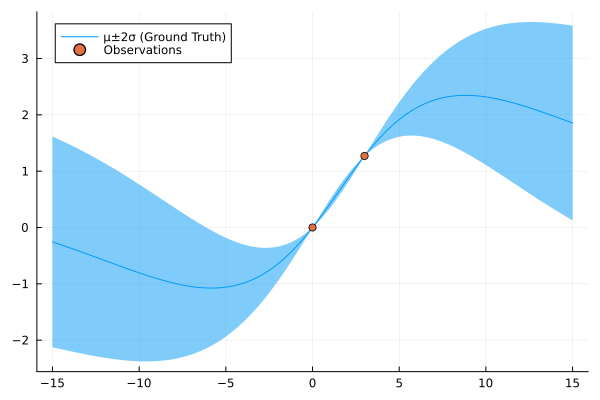

In [609]:
# X = sample_random_matrix(xmin, xmax, 1, n)
X = [0.;; 3.]
δX = rand(size(X)...)
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)
domain = xmin:.01:xmax

plot1D(sur; xmin=xmin, xmax=xmax, npts=1000)

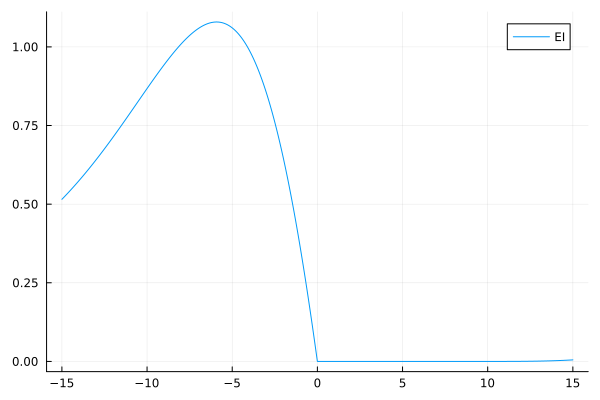

In [610]:
plot(domain, [sur([x]).EI for x in domain], label="EI")

In [615]:
T = Trajectory(Base.deepcopy(sur), [3.], h);

In [616]:
rollout!(T, [xmin], [xmax]; rnstream=lds_rns[1, :, :], xstarts=xstarts)

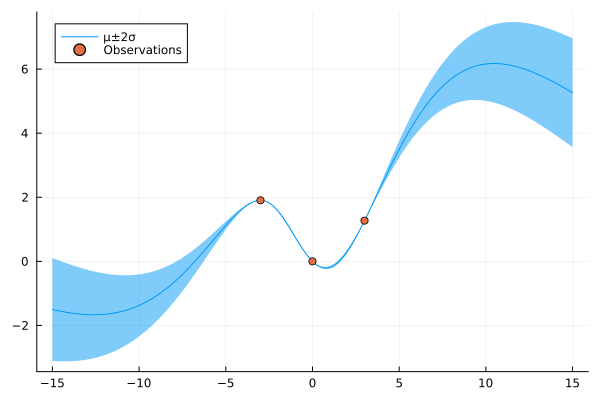

In [620]:
plot1D(T.mfs; xmin=xmin, xmax=xmax, npts=1000)

In [587]:
reset_fsurrogate!(T.fs, T.s)
reset_δsurrogate!(T.δfs, T.fs)
reset_mfsurrogate!(T.mfs, T.s)

In [589]:
Kold = T.mfs.K

12×12 Matrix{Float64}:
  1.0          0.930965    0.930965   …   0.983604    0.0226669
  0.930965     1.0         0.768993       0.861353    0.0545034
  0.930965     0.768993    1.0            0.979682   -0.025061
  0.0427136    0.0612143   0.0            0.025061    0.0143755
  0.999844     0.936708    0.925028       0.980367    0.0246643
 -0.00227821   0.0412631  -0.0441084  …  -0.0246643   0.0144426
  0.470979     0.647841    0.325526       0.397693    0.0488734
 -0.0544069   -0.0622152  -0.0423384     -0.0488734  -0.00407238
  0.790668     0.945521    0.604773       0.703123    0.0625814
 -0.0602312   -0.0388126  -0.0611556     -0.0625814   0.000295491
  0.983604     0.861353    0.979682   …   1.0        -0.0
  0.0226669    0.0545034  -0.025061       0.0         0.0166677

In [479]:
T.fs.X, length(T.fs.c)

([0.0 3.0 … 0.0 0.0], 2)

In [413]:
function get_trajectory_path(T::Trajectory)
    @assert T.fs.fantasies_observed == T.fs.h + 1 "Trajectory isn't fully rolled out!"
    M = T.mfs.known_observed + 1
    sample_path = T.mfs.X[:, M:end]
    return sample_path
end

get_trajectory_path (generic function with 1 method)

In [414]:
function visualize1D(T::Trajectory, lbs::Vector{Float64}, ubs::Vector{Float64})
    path = get_trajectory_path(T)[1, :]
    p = plot(
        0:T.h, path, color=:red, label=nothing, xlabel="Decision Epochs (h=$(T.h))",
        ylabel="Control Space (xʳ)", title="Trajectory Visualization in 1D",
        xticks=(0:T.h, ["x$(i)" for i in 0:T.h]), xrotation=45, grid=false
    )
    vline!(0:T.h, color=:black, linestyle=:dash, linewidth=1, label=nothing, alpha=.2)
    scatter!(0:T.h, path, color=:red, label=nothing)
    yticks!(
        round.(range(lbs[1], ubs[1], length=11), digits=1)
    )
    return p
end

function pvisualize1D(paths, lbs::Vector{Float64}, ubs::Vector{Float64})
    h = size(paths, 2)
    p = plot(
            0:h-1, paths[1, :], color=:red, label=nothing, xlabel="Decision Epochs (h=$(T.h))",
            ylabel="Control Space (xʳ)", title="Trajectory Visualization in 1D",
            xticks=(0:h, ["x$(i)" for i in 0:T.h]), xrotation=45, grid=false
        )
    vline!(p, 0:T.h, color=:black, linestyle=:dash, linewidth=1, label=nothing, alpha=.2)
    scatter!(p, 0:h-1, paths[1, :], color=:red, label=nothing)
    
    for i in 2:size(paths, 1)
        plot!(p, 0:h-1, paths[i, :], color=:red, label=nothing)
        scatter!(p, 0:h-1, paths[i, :], color=:red, label=nothing)
        yticks!(
            p, round.(range(lbs[1], ubs[1], length=11), digits=1)
        )
    end

    yticks!(
        p, round.(range(lbs[1], ubs[1], length=11), digits=1)
    )
        
    return p
end

pvisualize1D (generic function with 2 methods)

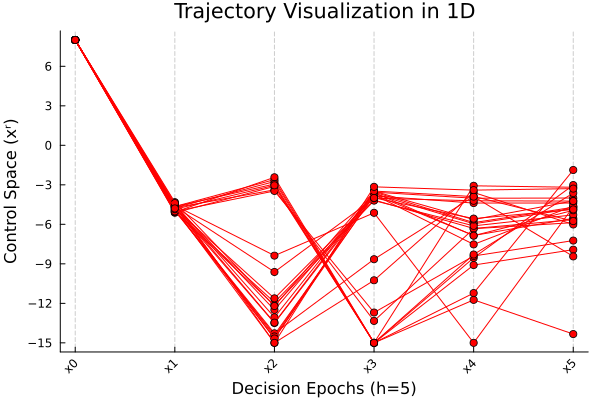

In [418]:
x0 = [8.]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

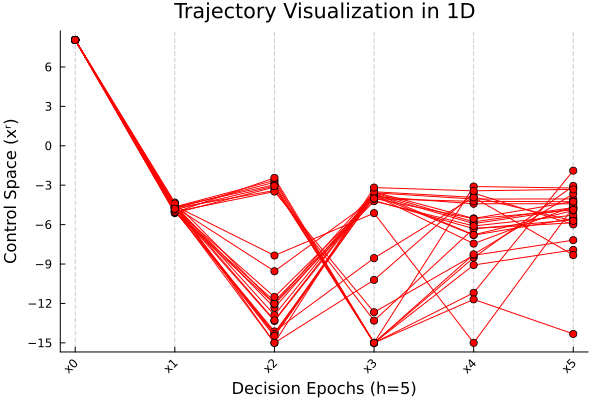

In [420]:
x0 = [8.] .+ rand()
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

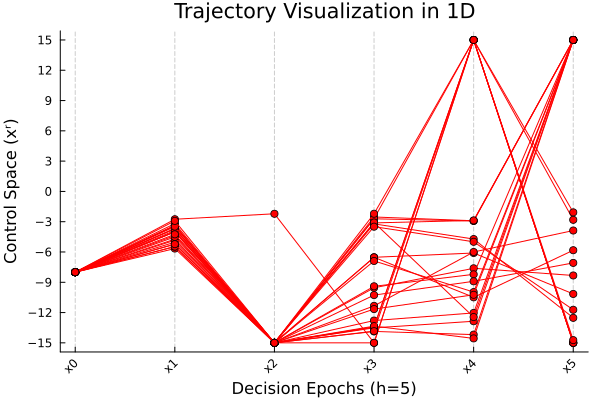

In [417]:
x0 = [-8.]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)

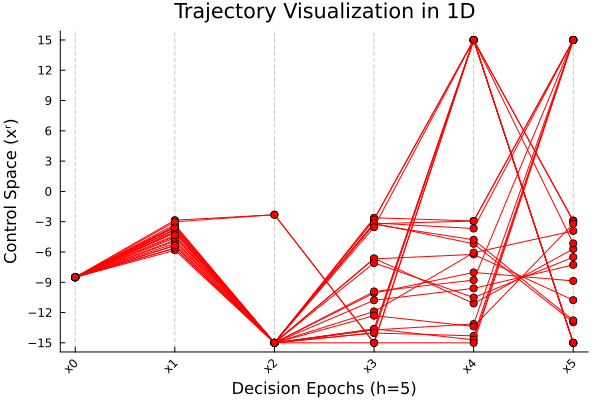

In [422]:
x0 = [-8.5]
paths = Matrix{Float64}(undef, 0, h+1)
for i in 1:MC_SAMPLES
    T = Trajectory(Base.deepcopy(sur), x0, h)
    rollout!(T, [xmin], [xmax]; rnstream=lds_rns[i, :, :], xstarts=xstarts)
    paths = vcat(paths, get_trajectory_path(T))
end

pvisualize1D(paths, lbs, ubs)